# Supervised Topic Classification 

## Version 2.0

Welcome to my Supervised Toppic Classification Learning Experiment, using the BBC News Kaggle dataset. This series of Notebooks is to serve myself, and potentially others, as I learn bits of NLP relating to topic classification. Each notebook is split into versions to capture my design and learning progress, and to demonstrate in situ the mistakes and poor judgement calls I make. 

As the end of each iteration, I will leave some notes to discuss how I will (hopefully) improve my work in future versions. 

See data source here https://www.kaggle.com/pariza/bbc-news-summary 

Last accessed on 2022-Mar-12.



In [3]:
# Import some standard dependencies
import numpy as np
import pandas as pd

In [4]:
# If you're cloning the gitlab repo, this cell wont work for you unless you save the data until a similar directory.
# Data is available in Notebook header text. 

import glob
files = glob.glob('data/News Articles/**/*.txt',
                  recursive=True)

### The Data

The data repo contains **five** folders, {business, entertainment, politics, sport, tech} each containing a `.txt` file corresponding to one Article. 

I know already, because I looked at *some* of them, that these files are pretty clean. There is no header/footer text to remove or other structural features, but there are a lot of symbols for currency (£, $, Eur), percentages (%) etc. So these will need to be handled. 

**Things to consider**
* The variation in article length
* The number of articles per 'label'

In [5]:
# We create data 'labels' by using the name of the folder the Article is saved in
labels,fileNames = zip(*[s.split('/')[2:] for s in files])
# Then make a pandas.DataFrame to store the data
corpus = pd.DataFrame(data = {
    "filePath":files, "topic":labels, "fileName":fileNames})

# Open and read each file, save to list, and append to the corpus pd.DataFrame
# "unicode_escape" files with the symbols in the text
text = []
for name in files:
    with open(name,"r",encoding="unicode_escape") as f:
        text.append(f.read())
corpus['text'] = text

### Label Encoding

This task is strictly multi-Class classification. See https://scikit-learn.org/stable/modules/multiclass.html

We want our articles to have one label (target). They are either business, or sport etc. but cannot be both. Having multiple possible labels would be a multi-LABEL classification problem. 

The type of problem determines how we need to encode our labels. 

See https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html

and https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

We will be doing Label Encoding, as we want to turn our string labels into numerical values which go from 0 to 1-n, where n = number of unique labels

In [39]:
# Create Encoded labels
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(corpus['topic'].unique())
corpus['topicLabel'] = le.transform(corpus['topic'])
# Is this overkill? Maybe. It it makes me happy.
le_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

In [7]:
# Lets check out our corpus DataFrame
corpus

,filePath,topic,fileName,text,topicLabel
0,data/News Articles/business/052.txt,business,052.txt,Italy to get economic action plan\n\nItalian P...,0
1,data/News Articles/business/019.txt,business,019.txt,India widens access to telecoms\n\nIndia has r...,0
2,data/News Articles/business/260.txt,business,260.txt,Asia shares defy post-quake gloom\n\nIndonesia...,0
3,data/News Articles/business/007.txt,business,007.txt,Jobs growth still slow in the US\n\nThe US cre...,0
4,data/News Articles/business/042.txt,business,042.txt,UK Coal plunges into deeper loss\n\nShares in ...,0
...,...,...,...,...,...
2220,data/News Articles/entertainment/335.txt,entertainment,335.txt,De Niro film leads US box office\n\nFilm star ...,1
2221,data/News Articles/entertainment/006.txt,entertainment,006.txt,Bennett play takes theatre prizes\n\nThe Histo...,1
2222,data/News Articles/entertainment/187.txt,entertainment,187.txt,Double eviction from Big Brother\n\nModel Capr...,1
2223,data/News Articles/entertainment/034.txt,entertainment,034.txt,Vera Drake scoops film award\n\nOscar hopefuls...,1


### Shuffle, Stratify, Test, Train, Split 

So, unlike Version 1.0, here we'll be following more well established procedure and splitting out our test dataset early. We'll also be doing some stratification, to ensure our test and test datasets are split proportionally.

This isn't going to help our ML model that much if our data topics have massively different populations, but I know already they are just about okay. We can shelve the outlier cases for another project. 

(I want to be a bit carful of my wording here. I have read that if the populations counts are very different, your ML of choice will struggle and you may need to do some sort of normalization process. Google imbalanced classes. This is a different problem to feature scaling.) See also [this link](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

In [8]:
corpus['topic'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: topic, dtype: int64

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
for train_index, test_index in split.split(corpus, corpus['topicLabel']):
    strat_train_set = corpus.loc[train_index]
    strat_test_set = corpus.loc[test_index]
# We're splitting 10 times (actually the default value for n_spilts) 
# to reshuffle the data 10 times. Somewhat overkill, and might quickly
# blow up for bigger datasets

In [10]:
strat_train_set['topic'].value_counts()/len(strat_train_set)

sport            0.229775
business         0.229213
politics         0.187079
tech             0.180337
entertainment    0.173596
Name: topic, dtype: float64

In [11]:
corpus['topic'].value_counts()/len(corpus)

sport            0.229663
business         0.229213
politics         0.187416
tech             0.180225
entertainment    0.173483
Name: topic, dtype: float64

In [12]:
strat_train_set

,filePath,topic,fileName,text,topicLabel
56,data/News Articles/business/391.txt,business,391.txt,Yukos heading back to US courts\n\nRussian oil...,0
558,data/News Articles/tech/022.txt,tech,022.txt,Sun offers processing by the hour\n\nSun Micro...,4
42,data/News Articles/business/072.txt,business,072.txt,S Korean consumers spending again\n\nSouth Kor...,0
485,data/News Articles/business/408.txt,business,408.txt,South African car demand surges\n\nCar manufac...,0
879,data/News Articles/tech/117.txt,tech,117.txt,Joke e-mail virus tricks users\n\nA virus that...,4
...,...,...,...,...,...
253,data/News Articles/business/270.txt,business,270.txt,Oil prices reach three-month low\n\nOil prices...,0
778,data/News Articles/tech/310.txt,tech,310.txt,Latest Opera browser gets vocal\n\nNet browser...,4
174,data/News Articles/business/179.txt,business,179.txt,Irish duo could block Man Utd bid\n\nIrishmen ...,0
1358,data/News Articles/sport/396.txt,sport,396.txt,Wales silent on Grand Slam talk\n\nRhys Willia...,3


### Transformation Pipeline

It is more consistent in bigger projects to ensure your transformations occur within a sklearn pipeline. This allows for more interoperabiltiy with sklearn tools, and allows for a more logical understanding of the steps taken. Or at least I think so. 

Anyway, here I am going ahead and creating a pipeline which carries out the **TfidfVectorization**, giving myself the flexibility _later_ to change properties such as:
* stop words
* ngram range
* other stuff?

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
textPreprocess_pipeline = Pipeline([
     ("tfidfVec", TfidfVectorizer(stop_words = 'english',ngram_range = (1,1)))
]) # for now I'm setting some keyword parameters to be explicit 

# These lines below are not used, but are here just to demonstrate how a parameter matrix is set up ...I think.
# Will need to be deleted/moved to the correct section at a later iteration. 
tf_params = {
    'tfidfVec__ngram_range':((1,1),(1,2)),
    'tfidfVec__stop_words':(None,'english')
}


### An Open Question

Should this **TfidfVectorization** step (and any later alterations to the text) be part of a discreet pre-processing step that is outside of GridSearch/Cross_val/RandomSearch? Or should it be part of one pipeline, including the model? I honestly don't know. 

In [27]:
# Lets try out this pipeline first, before we add more to it

tfidfTrain = textPreprocess_pipeline.fit_transform(strat_train_set['text'])

In [28]:
# Extracting components from a pipeline needs a little more unpacking, but it is possible
tfidf_features = textPreprocess_pipeline.named_steps['tfidfVec'].get_feature_names_out()

In [29]:
## TO DO - Beautify output for demonstration
pd.DataFrame(data = tfidfTrain.toarray(),columns = tfidf_features)
#textPreprocess_pipeline.named_steps['tfidfVec'].get_feature_names_out()

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,zooms,zooropa,zornotza,zorro,zubair,zuluaga,zurich,zutons,zvonareva,zvyagintsev
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.023236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.042693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.023043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1775,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1776,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1777,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1778,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### The Full Model Pipeline

We now bring in a model selection, which for a simple first-pass classification we will use two example models: 
* the SVC (Support Vector... Machine) and,
* the SGD (stocastic gradient descent) model.

In [15]:
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
svm_clf = SVC()
sgd_clf = SGDClassifier(random_state = 42) # for repeatability we provide a random state value

In [16]:
# Construct two pipelines for each model type 
svm_model_pipeline = Pipeline([
    ("tfidfVec", TfidfVectorizer(stop_words = 'english',ngram_range = (1,1))),
    ('svm',svm_clf)
])
sgd_model_pipeline = Pipeline([
    ("tfidfVec", TfidfVectorizer(stop_words = 'english',ngram_range = (1,1))),
    ('sgd',sgd_clf)
])

### Cross Val Score 

The cross val method is a common way to 'cheat' with your data and create sub-sets of test-train datasets using slices of only the training data. While this is done at the expense of computing power & time, it can ensure your model is overall more reliable. (I need to work on this wording, it's not the most convincing. Why is it more reliable? Less overfitting? More tests = more trustworthiness in find outputs?)

In [17]:
from sklearn.model_selection import cross_val_score

In [33]:
tfSVM_cvs = cross_val_score(svm_model_pipeline,
                            X = strat_train_set['text'], 
                            y = strat_train_set['topicLabel'],
                            cv = 5, # i.e. 3 cross val splits
                            scoring = 'accuracy' # default for SVC
                           )
# Warning -- Accuracy is not a typically a good metric for classification
# will be writing more on this later

In [34]:
tfSVM_cvs
print("For {} cross-val splits, the model accuracy outputs:\n".format(len(tfSVM_cvs)))
print("{}\n".format(tfSVM_cvs))

For 5 cross-val splits, the model accuracy outputs:

[0.98314607 0.96910112 0.9747191  0.96910112 0.98314607]



### Classification Accuracy

When it comes to classification problems, "accuracy" is often not the most reliable metric to judge your model. Admittedly, the raw outputs above are pretty good, and high enough be better than a "dumb" estimator that simply just guesses the topic. 

Instead, we'll look at measures such as the:
* **precision**
* **recall** 
* and the **confusion matrix**

To create these, we use **cross_val_predict**. This function, rather than **cross_val_score**, provides the predictions for each fold of the test data. This allows us to look deeper into how the model behaves, specifically letting us view the metrics on the number of false positives and false negatives. Of course, if the overall model accuracy is 100%, this wouldn't be required. However, knowing the rates of false +ives and false -ives gives us a better insight into how the model works, and lets us make better choices in tuning our model for the desired output based on our use-case.

Note: Precision, Recall, Confusion Matricies (and other processes such as the Precision-Recall curve and ROC curve) are often described in terms of binary classifiers in intro courses. I am resistant to including too many online sources, but [this article](https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2) on **Multi-Class Metrics Made Simple** from Towards Data Science by Boaz Shmueli might provide some insight.

In [19]:
from sklearn.model_selection import cross_val_predict

In [47]:
tfSVM_cvs

array([0.97979798, 0.96795953, 0.96795953])

In [20]:
# SVC Prediction Modelling
svm_cvp = cross_val_predict(svm_model_pipeline,
                            X = strat_train_set['text'], 
                            y = strat_train_set['topicLabel'],
                            cv = 3, # i.e. 3 cross val splits
                            #scoring = 'accuracy' # default for SVC
                           )

In [ ]:
# Stocastic Gradient Descent (SGD) Modelling 
sgd_cvp = cross_val_predict(sgd_model_pipeline,
                            X = strat_train_set['text'], 
                            y = strat_train_set['topicLabel'],
                            cv = 3, # i.e. 3 cross val splits
                            #scoring = 'accuracy' # default for SVC
                           )

### Confusion Matricies

In [118]:
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
#%matplotlib notebook

### 2022-06-26
I'm trying to play around with the ConfusionMatrixDisplay from sklearn
but... I'm coming to realise I shoudn't be trying to customize this
visualisation wrapper. It's just a quick-plot tool. 

If I want pretty figures, I should just use the data directly and 
customise in matplotlib and/or seaborn. D'oh.

<IPython.core.display.Javascript object>


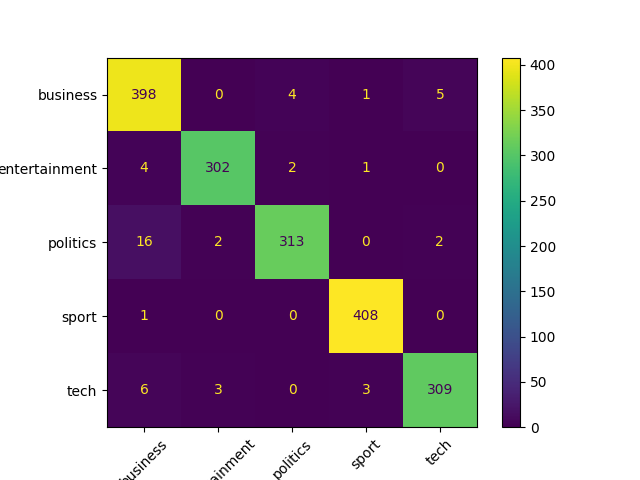

<IPython.core.display.Javascript object>


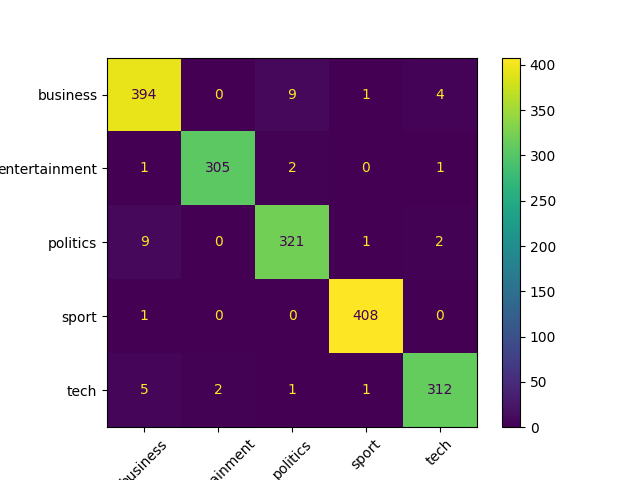

In [119]:
svc_conf_mx_disp =  ConfusionMatrixDisplay.from_predictions(strat_train_set['topicLabel'],
                                                            svm_cvp,
                                                          xticks_rotation = 45,
                                                          display_labels=le_mapping)

sgd_conf_mx_disp = ConfusionMatrixDisplay.from_predictions(strat_train_set['topicLabel'],
                                                           sgd_cvp,
                                                          xticks_rotation = 45,
                                                          display_labels=le_mapping)


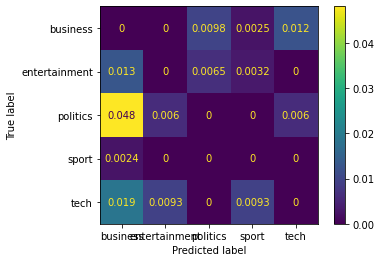

In [84]:
# Lets create a normalised confusion matrix which lets us focus on errors
norm_svm_conf_mx = svm_conf_mx / svm_conf_mx.sum(axis=1,keepdims=True)
np.fill_diagonal(norm_svm_conf_mx,0)
disp = ConfusionMatrixDisplay(confusion_matrix=norm_svm_conf_mx ,
                              display_labels=le_mapping)
disp.plot()

In [70]:
print(classification_report(strat_train_set['topicLabel'],svm_cvp,digits=3,target_names=le_mapping))

               precision    recall  f1-score   support

     business      0.936     0.975     0.956       408
entertainment      0.984     0.977     0.981       309
     politics      0.981     0.940     0.960       333
        sport      0.988     0.998     0.993       409
         tech      0.978     0.963     0.970       321

     accuracy                          0.972      1780
    macro avg      0.973     0.971     0.972      1780
 weighted avg      0.972     0.972     0.972      1780



### --- WARNING ---
The classification_report output generates an F1 score, and so it might be tempting to try
and compare F1 scores within the SVC output, and overall compare SVC to the SGD (which is coming up next).

But this can be very risky. The F1 value is not a direct measure of the model "goodness". 
It is a harmonic mean of the precision and recall,
make sure to check out the article Part 2 in the start of this section, or [here](https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1). 

If you want the brief answer, the F1 is dangerous as gives equal importance to the recall and the precision, when in fact most problems in real data science only care about one or the other. This is dangerous in a binary classifier, and even worse in a multiclass classifier. To use the phrase in the article, "...predicting X as Y is likely to have a different cost than predicting Z as W,...The standard F1-scores do not take any of the domain knowledge into account.". 

In [25]:
# Stocastic Gradient Descent (SGD) Modelling 
sgd_cvp = cross_val_predict(sgd_model_pipeline,
                            X = strat_train_set['text'], 
                            y = strat_train_set['topicLabel'],
                            cv = 3, # i.e. 3 cross val splits
                            #scoring = 'accuracy' # default for SVC
                           )

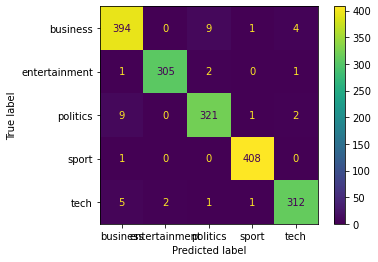

In [58]:
sgd_conf_mx = confusion_matrix(strat_train_set['topicLabel'],sgd_cvp)
disp = ConfusionMatrixDisplay(confusion_matrix=sgd_conf_mx,
                              display_labels=le_mapping)
disp.plot()

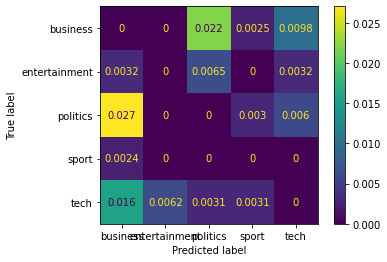

In [67]:
# Lets create a normalised confusion matrix which lets us focus on errors
norm_sgd_conf_mx = sgd_conf_mx / sgd_conf_mx.sum(axis=1,keepdims=True)
np.fill_diagonal(norm_sgd_conf_mx,0)
disp = ConfusionMatrixDisplay(confusion_matrix=norm_sgd_conf_mx ,
                              display_labels=le_mapping)
disp.plot()

In [45]:
print(classification_report(strat_train_set['topicLabel'],sgd_cvp,digits=3,target_names=le_mapping))

               precision    recall  f1-score   support

     business      0.961     0.966     0.963       408
entertainment      0.993     0.987     0.990       309
     politics      0.964     0.964     0.964       333
        sport      0.993     0.998     0.995       409
         tech      0.978     0.972     0.975       321

     accuracy                          0.978      1780
    macro avg      0.978     0.977     0.978      1780
 weighted avg      0.978     0.978     0.978      1780

